In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

In [2]:
df = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1')
df.head()

FileNotFoundError: ignored

In [ ]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})

In [ ]:
df.shape

(4845, 2)

In [ ]:


df.index = range(4845)
df['Message'].apply(lambda x: len(x.split(' '))).sum()



111964

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


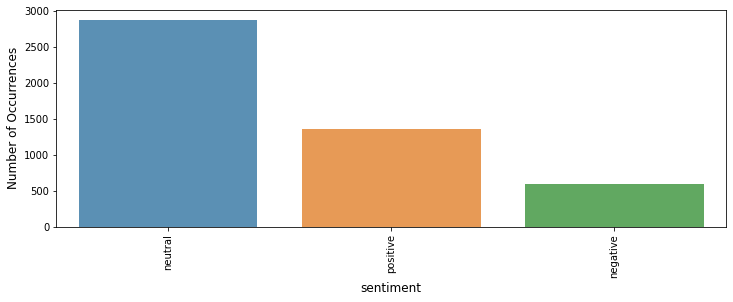

In [ ]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:


#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

df.sentiment = [sentiment[item] for item in df.sentiment] 
print(df)



      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [ ]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .
Message: 0


In [ ]:
print_message(0)

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
Message: 1


In [ ]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

In [ ]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4845 unique tokens.


In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4845 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


In [ ]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', "''", 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

In [ ]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 4844/4844 [00:00<00:00, 954576.61it/s]


In [ ]:


%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha



100%|██████████| 4844/4844 [00:00<00:00, 2485285.45it/s]


CPU times: user 12.6 s, sys: 97.7 ms, total: 12.7 s
Wall time: 12.8 s


In [ ]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [ ]:
len(d2v_model.wv.vocab)

11683

In [ ]:


# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])



In [ ]:


d2v_model.wv.most_similar(positive=['profit'], topn=10)



[('loss', 0.8866175413131714),
 ('profits', 0.8121187686920166),
 ('income', 0.8000516891479492),
 ('sales', 0.7743803262710571),
 ('pharma', 0.7630947828292847),
 ('walby', 0.740184485912323),
 ('mistake', 0.7308052182197571),
 ('attempt', 0.7237218618392944),
 ('68.3', 0.6942218542098999),
 ('assumption', 0.6927779912948608)]

In [ ]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('placed', 0.7212769389152527),
 ('hardest', 0.7211957573890686),
 ('motorcyclist', 0.6949337124824524),
 ('total', 0.6912533044815063),
 ('eur58m', 0.6843326687812805),
 ('assets', 0.684025764465332),
 ('8,000', 0.6766244173049927),
 ('fund', 0.6705489158630371),
 ('gone', 0.6692916750907898),
 ('kemij+ã\x86rvi', 0.6580835580825806)]

In [ ]:


d2v_model.wv.most_similar(positive=['broke'], topn=10)



[('mold', 0.9821630716323853),
 ('macro-economic', 0.8481729030609131),
 ('warmly', 0.8410474061965942),
 ('aptly', 0.8385289907455444),
 ('hassinen', 0.8376088738441467),
 ('gather', 0.8331302404403687),
 ('stole', 0.817965030670166),
 ('remarked', 0.8111373782157898),
 ('burgundy', 0.8062671422958374),
 ('impulse', 0.8027645349502563)]

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in d2v_model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 134 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 156 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 134 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, fla

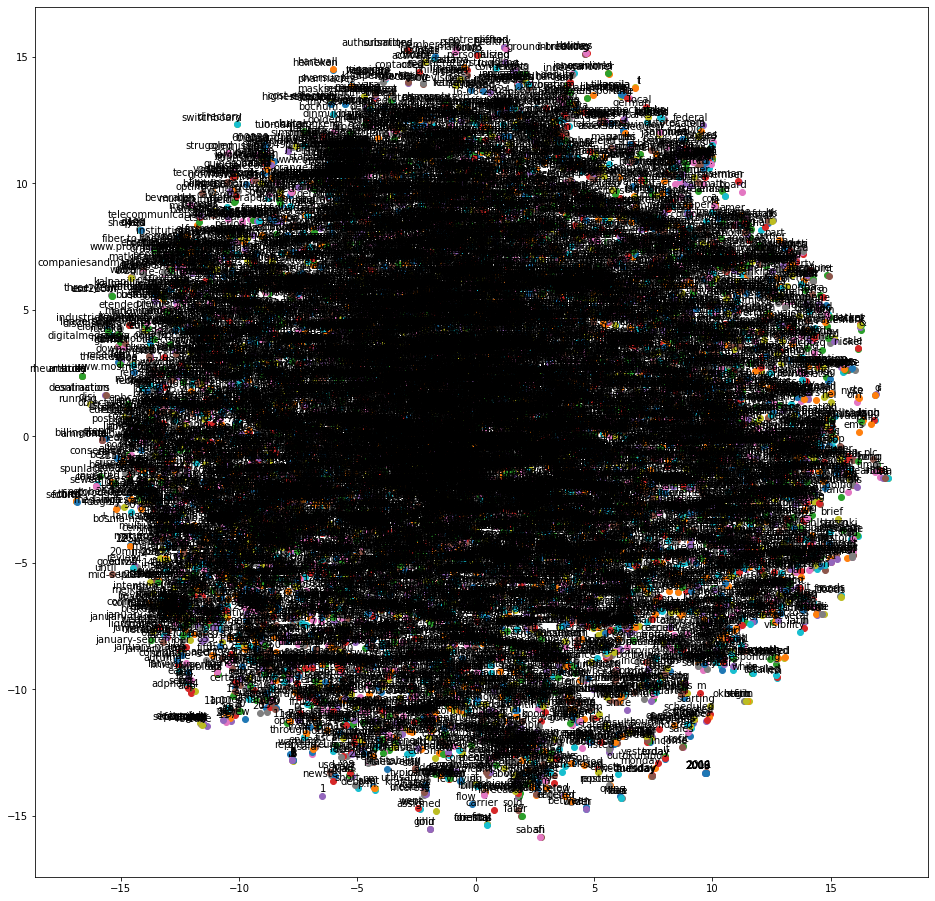

In [ ]:
tsne_plot(d2v_model)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            233680    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 248,033
Trainable params: 248,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: ignored

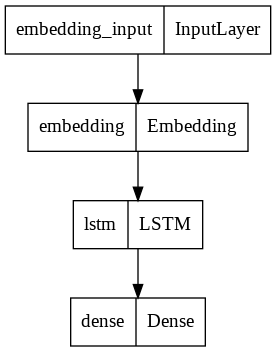

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [ ]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 6s - loss: 0.5478 - acc: 0.6051 - 6s/epoch - 47ms/step
Epoch 2/50
129/129 - 3s - loss: 0.4191 - acc: 0.6982 - 3s/epoch - 27ms/step
Epoch 3/50
129/129 - 3s - loss: 0.3000 - acc: 0.7919 - 3s/epoch - 27ms/step
Epoch 4/50
129/129 - 4s - loss: 0.2367 - acc: 0.8363 - 4s/epoch - 27ms/step
Epoch 5/50
129/129 - 3s - loss: 0.2154 - acc: 0.8463 - 3s/epoch - 27ms/step
Epoch 6/50
129/129 - 3s - loss: 0.1825 - acc: 0.8677 - 3s/epoch - 27ms/step
Epoch 7/50
129/129 - 3s - loss: 0.1522 - acc: 0.9065 - 3s/epoch - 27ms/step
Epoch 8/50
129/129 - 3s - loss: 0.1028 - acc: 0.9480 - 3s/epoch - 27ms/step
Epoch 9/50
129/129 - 3s - loss: 0.0711 - acc: 0.9667 - 3s/epoch - 27ms/step
Epoch 10/50
129/129 - 3s - loss: 0.0527 - acc: 0.9772 - 3s/epoch - 27ms/step
Epoch 11/50
129/129 - 3s - loss: 0.0355 - acc: 0.9849 - 3s/epoch - 27ms/step
Epoch 12/50
129/129 - 3s - loss: 0.0407 - acc: 0.9815 - 3s/epoch - 27ms/step
Epoch 13/50
129/129 - 3s - loss: 0.0309 - acc: 0.9871 - 3s/epoch - 27ms/step
Epoch 14

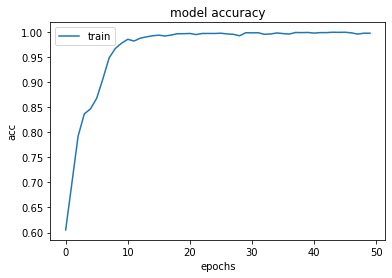

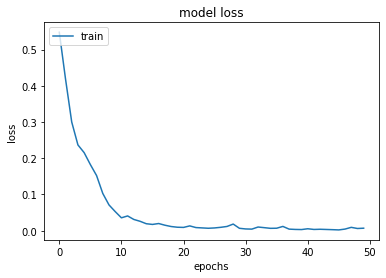

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - loss: 0.0054 - acc: 0.9976 - 1s/epoch - 11ms/step
23/23 - 0s - loss: 1.1077 - acc: 0.7111 - 187ms/epoch - 8ms/step
Train: 0.998, Test: 0.7111


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
# yhat_classes = model.predict_classes(X_test, verbose=0)


predict_x=model.predict(X_test) 
yhat_classes=np.argmax(predict_x,axis=1)

print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[1.3681840e-05 9.9997783e-01 8.4885178e-06]
 [9.9998379e-01 7.6315519e-06 8.6225227e-06]
 [2.7367363e-07 9.9999952e-01 2.0719666e-07]
 ...
 [9.9974424e-01 3.8020265e-05 2.1770796e-04]
 [3.5098088e-07 9.9999940e-01 2.9017804e-07]
 [2.9511410e-01 6.6665560e-01 3.8230319e-02]]
[1 0 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 0 2 1 1 0 0 1 0 1 1 0 2 1 1 1 2 1 1 2
 0 1 1 0 1 2 0 0 1 1 1 0 1 2 1 0 2 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1
 0 1 1 1 1 2 1 2 0 1 0 0 1 0 1 0 0 1 1 2 1 1 0 1 0 1 0 1 1 2 0 1 1 1 2 1 1
 1 2 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 2 1 0 1 0 1 1 1 1 1 1 1 1 1 2 1
 2 1 1 0 1 2 1 0 0 1 2 2 0 1 1 0 1 0 1 2 1 0 1 0 0 1 0 2 0 0 1 0 0 0 0 1 1
 2 1 2 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 2 1 0 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 2 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 2 1 0 2 1 0 1 1 1
 1 1 0 1 0 1 2 2 1 1 1 1 1 2 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 2 2 1
 1 2 0 1 0 1 1 1 1 2 1 0 1 1 1 2 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 0 0 1 0 0 1 0 1 2 1 2 1 1 0 1 0 1 1 1 0 

In [ ]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[124,  86,   5],
       [ 62, 343,  21],
       [ 12,  24,  50]])

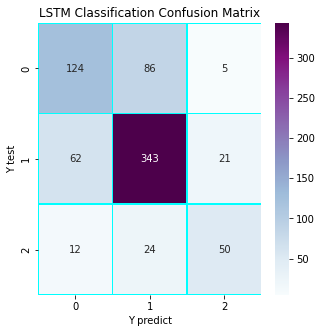

In [ ]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()



In [ ]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 9ms/step - loss: 1.2527 - acc: 0.7607
score: 1.25
acc: 0.76


In [ ]:
model.save('Mymodel.h5')

In [ ]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[0.19447339 0.0042632  0.80126345]] 2


In [ ]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[9.1719836e-01 2.6808359e-04 8.2533598e-02]] 0


In [ ]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[1.2795937e-10 1.0000000e+00 2.0530620e-10]] 1


In [ ]:


message = ['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])



[[9.9999416e-01 2.4743952e-06 3.3426595e-06]] 0


In [ ]:
message = ['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[5.5986973e-08 1.0000000e+00 4.5340929e-08]] 1


In [ ]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[2.7246273e-07 6.2852443e-08 9.9999964e-01]] 2
